# Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from brian2 import *
from brian2tools import brian_plot, plot_state
from IPython.display import HTML

from TacNet import TacNet
from utils import display_video

set_device('cpp_standalone')

def wrap2pi(angles):
    theta = np.array(angles)
    theta = theta.reshape(-1)
    n = np.floor(theta/np.pi)
    return theta - n*np.pi

def extend_dataset(data, labels, n=1, crop=None):
    if not isinstance((data, labels), (np.ndarray, np.ndarray)):
        data = np.asarray(data)
        labels = np.asarray(labels)
        
    if crop is not None:
        data = data[:crop, :, :]
        labels = labels[:crop, ]
        
    return np.repeat(data, n, axis=0), np.repeat(labels, n, axis=0)

# Unsupervised Learning of Edge Orientation Detection with [TacNet](TacNet.py)

INFO:root:creating /tmp/brian_flag_test_1v8nacwb/tmp
INFO:root:creating /tmp/brian_flag_test_1v8nacwb/tmp/brian_flag_test_1v8nacwb
INFO:root:/home/alex/miniconda3/envs/brian/bin/x86_64-conda-linux-gnu-cc -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/alex/miniconda3/envs/brian/include -fPIC -O2 -isystem /home/alex/miniconda3/envs/brian/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/alex/miniconda3/envs/brian/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/alex/miniconda3/envs/brian/include -fPIC -c /tmp/brian_flag_test_1v8nacwb/flag_test.cpp -o /tmp/brian_flag_test_1v8nacwb/tmp/brian_flag_test_1v8nacwb/flag_test.o -w
INFO:root:creating /tmp/brian_flag_test_cfvfjcyr/tmp
INFO:root:creating /tmp/brian_flag_test_cfvfjcyr/tmp/brian_flag_test_cfvfjcyr
INFO:root:/home/alex/miniconda3/envs/brian/bin/x86_64-conda-linux-gnu-cc -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/alex/miniconda

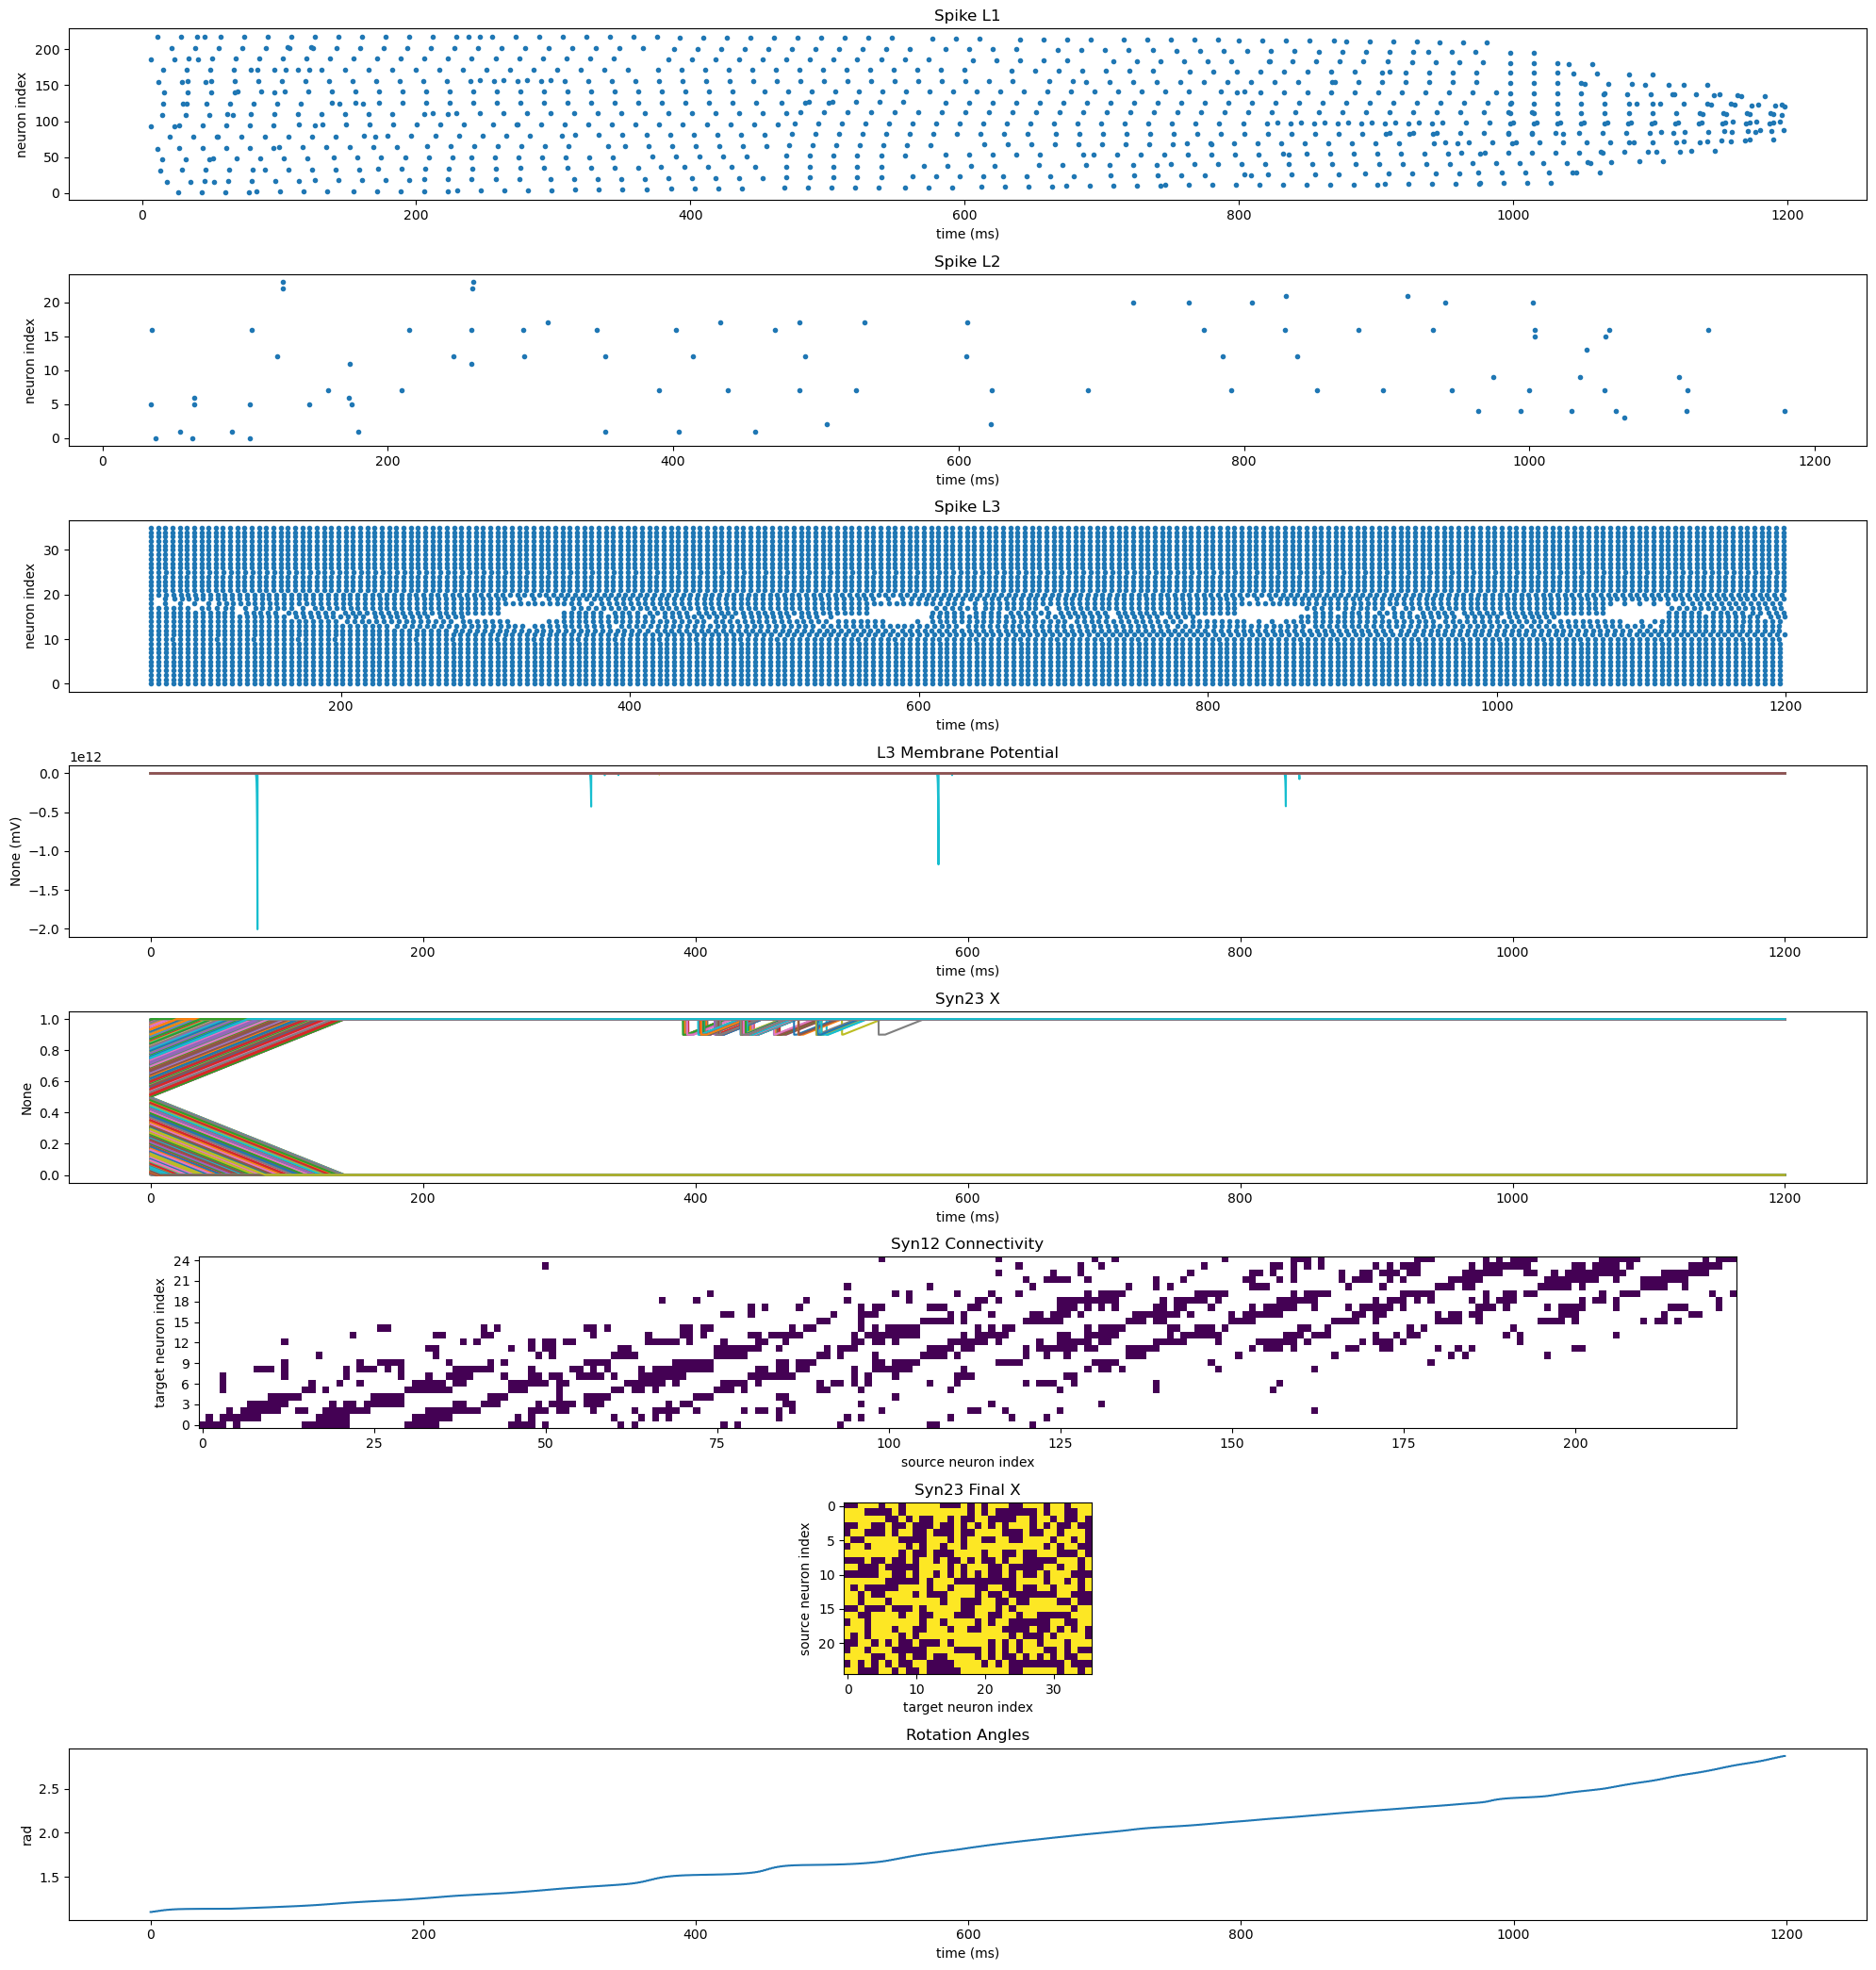

In [2]:
# Prepare dataset
dt = 1*ms
site_name = 'sharp_site'
dataset = np.load("../data/touch.pkl", allow_pickle=True)
sensordata = dataset[site_name]['sensordata']
rot_orientations = dataset[site_name]['orientations']
data, orientations = extend_dataset(sensordata, rot_orientations, n=2, crop=600)

# Convert values to spikes
length, height, width = data.shape
inputs = data.reshape(length, -1)
inputs[inputs > 0] = 1.
I = TimedArray(inputs*200*pA, dt=dt)

# Prepare simulation
duration = I.values.shape[0]*dt
num_neurons = [height*width, 25, 36]
model = TacNet(num_neurons)
mons = model.run(I, duration)

# Plot results
fig, axs = plt.subplots(8, 1, figsize=(20, 21))
for i in range(3):
    axs[i].set_title('Spike L'+str(i+1))
    brian_plot(mons['SpikeMonitor_L'+str(i+1)], axes=axs[i])

axs[3].set_title('L3 Membrane Potential')
plot_state(mons['StateMonitor_L3'].t, mons['StateMonitor_L3'].v.T, axes=axs[3])
axs[4].set_title('Syn23 X')
plot_state(mons['StateMonitor_Syn23'].t,
            mons['StateMonitor_Syn23'].X.T, axes=axs[4])
axs[5].set_title('Syn12 Connectivity')
brian_plot(model.net['Syn12'], axes=axs[5])
axs[6].set_title('Syn23 Final X')
axs[6].set_xlabel('target neuron index')
axs[6].set_ylabel('source neuron index')
axs[6].imshow(model.net['Syn23'].X_[:].reshape((num_neurons[1], num_neurons[2])))
axs[7].plot(wrap2pi(orientations))
axs[7].set_title('Rotation Angles')
axs[7].set_xlabel('time (ms)')
axs[7].set_ylabel('rad')
plt.tight_layout()
plt.show()

# Reference
1. F. Pascal, L. Bombrun, J. -Y. Tourneret and Y. Berthoumieu, "Parameter Estimation For Multivariate Generalized Gaussian Distributions," in IEEE Transactions on Signal Processing, vol. 61, no. 23, pp. 5960-5971, Dec.1, 2013, doi: 10.1109/TSP.2013.2282909.
2. A. Parvizi-Fard, M. Amiri, D. Kumar, M. M. Iskarous, and N. V. Thakor, “A functional spiking neuronal network for tactile sensing pathway to process edge orientation,” Sci Rep, vol. 11, no. 1, p. 1320, Dec. 2021, doi: 10.1038/s41598-020-80132-4.
3. J. A. Pruszynski and R. S. Johansson, “Edge-orientation processing in first-order tactile neurons,” Nat Neurosci, vol. 17, no. 10, pp. 1404–1409, Oct. 2014, doi: 10.1038/nn.3804.
4. J. M. Yau, S. S. Kim, P. H. Thakur, and S. J. Bensmaia, “Feeling form: the neural basis of haptic shape perception,” Journal of Neurophysiology, vol. 115, no. 2, pp. 631–642, Feb. 2016, doi: 10.1152/jn.00598.2015.
5. G. Sutanto, Z. Su, S. Schaal, and F. Meier, “Learning Sensor Feedback Models from Demonstrations via Phase-Modulated Neural Networks,” in 2018 IEEE International Conference on Robotics and Automation (ICRA), Brisbane, QLD, May 2018, pp. 1142–1149. doi: 10.1109/ICRA.2018.8460986.
6. A. Handler and D. D. Ginty, “The mechanosensory neurons of touch and their mechanisms of activation,” Nat Rev Neurosci, vol. 22, no. 9, pp. 521–537, Sep. 2021, doi: 10.1038/s41583-021-00489-x.